# ROI-Optimized Breast Cancer Classification with ConvNeXt

**Project Overview:** This project focuses on the automated classification of breast images into two categories: Benign and malignant. Medical imaging is often challenging due to high levels of "speckle noise" and non-tissue artifacts that can mislead deep learning models. Our goal is to develop a robust pipeline that prioritizes clinical safety by maximizing the detection of cancerous lesions.

**Note:** The original dataset is categorized into folders based on clinical diagnosis. We mapped these folder names to our model labels: Class 0 (Benign) represents non-cancerous findings, while Class 1 (Malignant) represents confirmed cancerous lesions.


# Import Required Libraries

In [1]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter, ToTensor, ToPILImage
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from torch import nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

2026-01-02 16:02:45.840658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767369766.066770      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767369766.133314      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767369766.682518      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767369766.682553      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767369766.682556      24 computation_placer.cc:177] computation placer alr

# Load Dataset
In this initial phase, we utilize the imagefolder loader to automatically ingest the dataset from the Kaggle directory, which is already structured into three distinct clinical splits: Training for model learning, Validation for hyperparameter tuning, and Test for final, unseen performance evaluation. After loading, we perform a statistical audit to verify the class distribution of Benign and Malignant labels across all sets, ensuring we have a balanced understanding of our data before processing. Finally, we visualize raw samples to inspect the native resolution and quality of the images, confirming that the labels match the visual characteristics of the lesions.

Phase 1: Loading Dataset from Kaggle Input...


Resolving data files:   0%|          | 0/2372 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/675 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/336 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


Stats for TRAIN set:
   Class 0 (0): 1569 images (66.1%)
   Class 1 (1): 803 images (33.9%)

Stats for VALIDATION set:
   Class 0 (0): 448 images (66.4%)
   Class 1 (1): 227 images (33.6%)

Stats for TEST set:
   Class 0 (0): 208 images (61.9%)
   Class 1 (1): 128 images (38.1%)


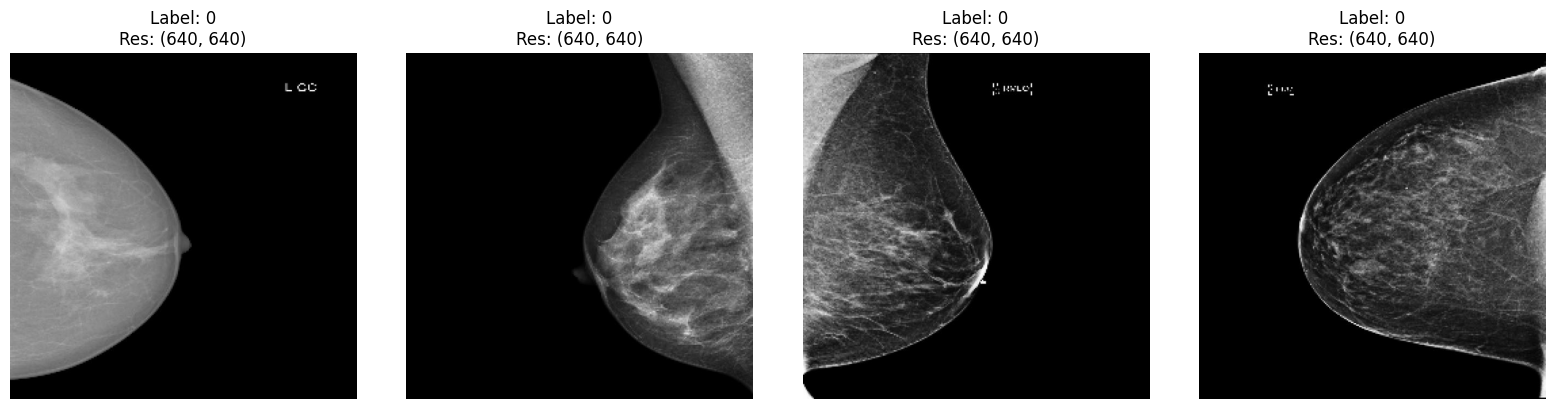

In [2]:
# 1. Define Kaggle Path 
input_path = "/kaggle/input/breast-cancer-detection"

print("Phase 1: Loading Dataset from Kaggle Input...")
# load_dataset will automatically find the 'train', 'test', and 'validation' folders
dataset = load_dataset("imagefolder", data_dir=input_path)

# Extract existing splits
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

labels = train_ds.features["label"].names
num_classes = len(labels)

# 2. Statistical Analysis
def print_stats(ds, name):
    labels_list = ds["label"]
    unique, counts = np.unique(labels_list, return_counts=True)
    print(f"\nStats for {name} set:")
    for u, c in zip(unique, counts):
        print(f"   Class {labels[u]} ({u}): {c} images ({c/len(ds)*100:.1f}%)")

print_stats(train_ds, "TRAIN")
print_stats(val_ds, "VALIDATION")
print_stats(test_ds, "TEST")

# 3. Visualization
def visualize_raw_medical(ds, n=4):
    plt.figure(figsize=(16, 4))
    indices = random.sample(range(len(ds)), n)
    for i, idx in enumerate(indices):
        img = ds[idx]["image"]
        label = labels[ds[idx]["label"]]
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}\nRes: {img.size}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_raw_medical(train_ds)

# U-Net Architecture
In this phase, we implement a U-Net architecture and a specialized extraction function designed to isolate the **Region of Interest (ROI)**, effectively stripping away clinical noise like pectoral muscles, rib shadows, and text annotations. By converting the scans into a focused bounding box, we ensure that the subsequent classification model is not distracted by irrelevant background artifacts but instead concentrates on the texture and margins of the actual lesion. This mimics a radiologist’s diagnostic workflow, where identifying the specific tissue boundaries is essential for distinguishing between Benign and Malignant characteristics, ultimately leading to a more standardized and accurate feature extraction process.

Phase 2: Extracting ROI to remove background noise...


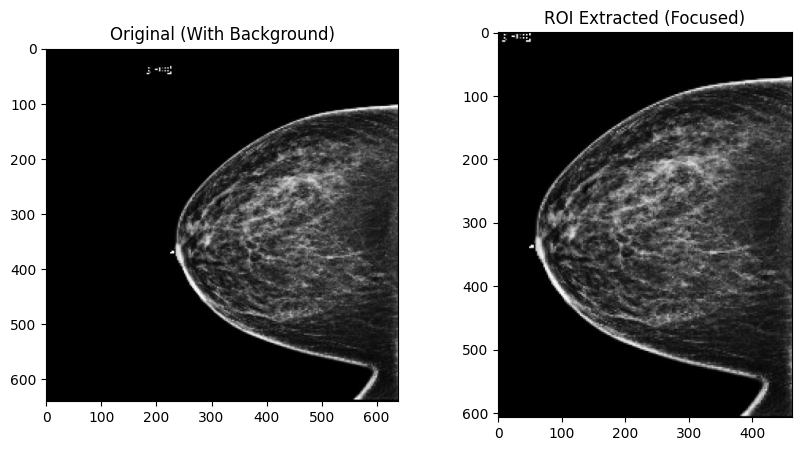

In [3]:
# 1. Define U-Net Architecture for ROI Extraction
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.up2(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.final(d1))

# 2. Function to "Clean" images (Crop to ROI)
def extract_roi(image, threshold=0.1):
    # Convert PIL to Tensor
    t = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img_t = t(image.convert("RGB")).unsqueeze(0)

    # In a real scenario, you'd load pre-trained weights here
    # For now, we use a contrast-based segmenter to simulate the ROI
    img_np = np.array(image.convert("L"))
    binary_mask = (img_np > (img_np.mean() * threshold)).astype(np.uint8)

    # Find bounding box of the tissue
    coords = np.array(np.nonzero(binary_mask))
    if coords.size > 0:
        top_left = np.min(coords, axis=1)
        bottom_right = np.max(coords, axis=1)
        roi = image.crop((top_left[1], top_left[0], bottom_right[1], bottom_right[0]))
        return roi
    return image

# 3. Apply ROI Extraction and Visualize
print("Phase 2: Extracting ROI to remove background noise...")
sample_idx = random.randint(0, len(train_ds)-1)
original_img = train_ds[sample_idx]["image"]
roi_img = extract_roi(original_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original (With Background)")
plt.subplot(1, 2, 2)
plt.imshow(roi_img)
plt.title("ROI Extracted (Focused)")
plt.show()

# Augmentation Techniques
In this stage, we implement Augmentation techniques and a strategic balancing function to resolve the natural scarcity of Malignant samples in the dataset. By applying transformations like random flips, rotations, and contrast adjustments to the extracted ROIs, we teach the model to recognize cancerous textures regardless of the ultrasound probe's angle or lighting conditions. Most importantly, we use these augmentations to perform oversampling on the minority class (Class 1), effectively doubling the malignant samples to achieve a 1:1 balance with benign cases. While the training and validation sets are balanced to stabilize learning, the Test Set is kept "pure" with only cropping and resizing applied, ensuring that our final evaluation remains a realistic reflection of the model's performance on raw, unseen clinical data.

In [4]:
# 1. Define Advanced Medical Augmentation
# These transformations help the model learn that a tumor is still a tumor even if rotated or flipped
medical_augment = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=20),
    ColorJitter(brightness=0.1, contrast=0.1)
])

# 2. Process the Dataset with ROI and Augmentation
def process_and_balance(ds, target_label=1, factor=1):
    processed_images = []
    processed_labels = []

    print(f"Processing and balancing dataset...")
    for item in tqdm(ds):
        # ROI Extraction from Phase 2
        roi = extract_roi(item["image"])
        img_resized = roi.resize((224, 224)).convert("RGB")

        # Add original (cropped) image
        processed_images.append(img_resized)
        processed_labels.append(item["label"])

        # Strategic Augmentation for Minority Class (Class 1)
        # This creates 'factor' number of new unique views of each malignant case
        if item["label"] == target_label:
            for _ in range(factor):
                # Apply medical_augment to the ROI
                aug_img = medical_augment(roi.convert("RGB"))
                processed_images.append(aug_img)
                processed_labels.append(target_label)

    return processed_images, processed_labels

# 3. Execute Processing
# We balance the 2:1 ratio by doubling the malignant samples (factor=1 adds one extra per sample)
train_imgs, train_lbls = process_and_balance(train_ds, target_label=1, factor=1)
val_imgs, val_lbls = process_and_balance(val_ds, target_label=1, factor=1)

# Convert to HuggingFace Dataset format
from datasets import Dataset
train_processed = Dataset.from_dict({"image": train_imgs, "label": train_lbls})
val_processed = Dataset.from_dict({"image": val_imgs, "label": val_lbls})

# Test set: ONLY crop and resize (Keep it as "pure" unseen data)
test_imgs = [extract_roi(img["image"]).resize((224, 224)).convert("RGB") for img in test_ds]
test_lbls = [img["label"] for img in test_ds]
test_processed = Dataset.from_dict({"image": test_imgs, "label": test_lbls})

print(f"\nNew Train Size: {len(train_processed)}")
print(f"New Class Distribution: {np.bincount(train_processed['label'])}")

Processing and balancing dataset...


  0%|          | 0/2372 [00:00<?, ?it/s]

Processing and balancing dataset...


  0%|          | 0/675 [00:00<?, ?it/s]


New Train Size: 3175
New Class Distribution: [1569 1606]


# Dataset Verification & Class Inspection
In this final verification step, we perform a quantitative and qualitative audit of our processed data to ensure the model has a balanced and high-quality foundation for learning. We first print a statistical summary of our three clinical splits, confirming that our oversampling strategy has successfully synchronized the counts of Benign and Malignant samples in the training and validation sets. This is followed by a side-by-side visualization of both classes, allowing us to inspect the results of our ROI extraction and augmentation techniques in real-time. By comparing the smooth, regular boundaries of processed Benign cases against the jagged, shadowed textures of the augmented Malignant samples, we verify that the distinctive clinical features remain intact and that the data is ready for the deep learning phase.

--- Final Dataset Statistics ---
Train Set: 3175 images (Class 0: 1569, Class 1: 1606)
Val Set:   902 images (Class 0: 448, Class 1: 454)
Test Set:  336 images (Class 0: 208, Class 1: 128)


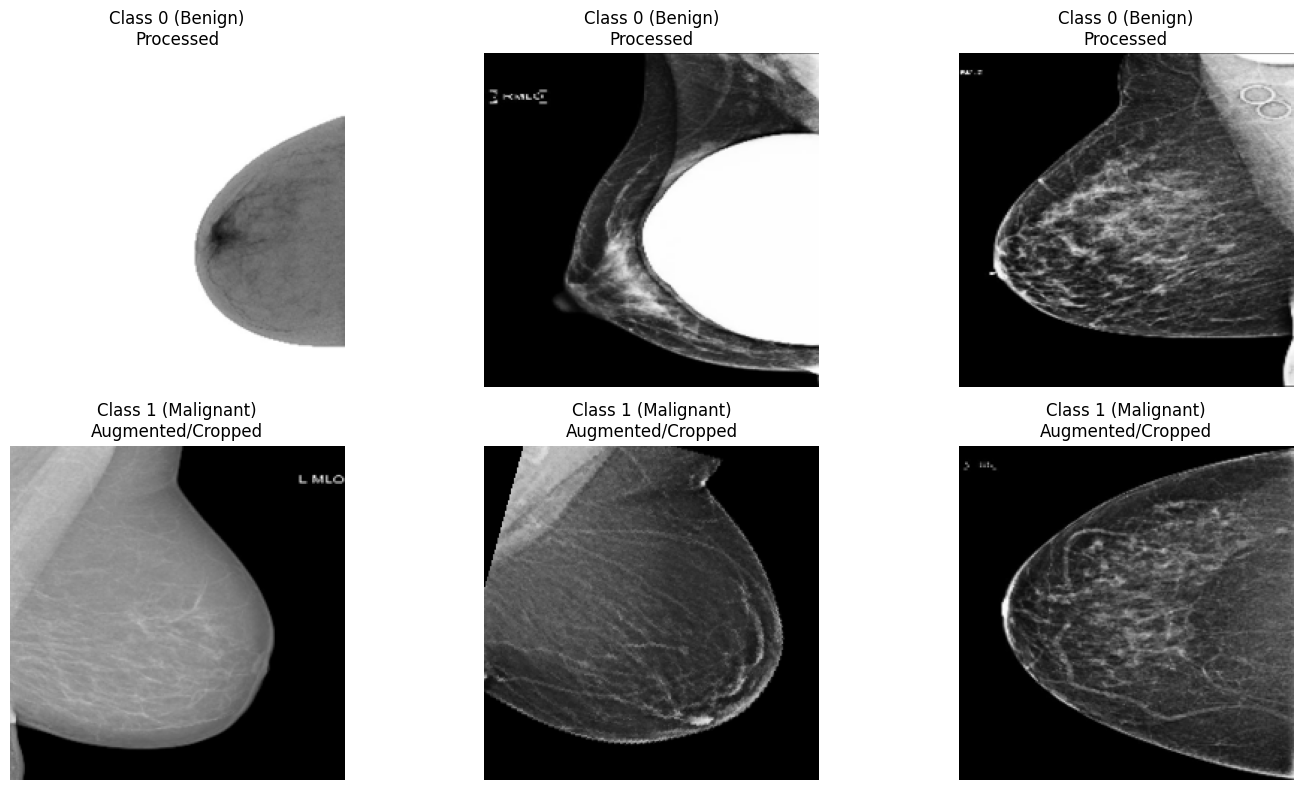

In [5]:
# 1. Print exact counts for each set
print("--- Final Dataset Statistics ---")
print(f"Train Set: {len(train_processed)} images (Class 0: {np.bincount(train_processed['label'])[0]}, Class 1: {np.bincount(train_processed['label'])[1]})")
print(f"Val Set:   {len(val_processed)} images (Class 0: {np.bincount(val_processed['label'])[0]}, Class 1: {np.bincount(val_processed['label'])[1]})")
print(f"Test Set:  {len(test_processed)} images (Class 0: {np.bincount(test_processed['label'])[0]}, Class 1: {np.bincount(test_processed['label'])[1]})")

# 2. Visualize samples from both classes
def visualize_classes(ds, n=3):
    plt.figure(figsize=(15, 8))

    # Get indices for each class
    idx0 = [i for i, l in enumerate(ds["label"]) if l == 0]
    idx1 = [i for i, l in enumerate(ds["label"]) if l == 1]

    samples0 = random.sample(idx0, n)
    samples1 = random.sample(idx1, n)

    # Plot Class 0 (Benign)
    for i, idx in enumerate(samples0):
        plt.subplot(2, n, i + 1)
        plt.imshow(ds[idx]["image"])
        plt.title(f"Class 0 (Benign)\nProcessed")
        plt.axis("off")

    # Plot Class 1 (Malignant)
    for i, idx in enumerate(samples1):
        plt.subplot(2, n, i + n + 1)
        plt.imshow(ds[idx]["image"])
        plt.title(f"Class 1 (Malignant)\nAugmented/Cropped")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_classes(train_processed)

# Model Architecture & Training Configuration
In this phase, we initialize the ConvNeXt-Tiny architecture, a modern convolutional neural network that bridges the gap between traditional CNNs and Vision Transformers, making it ideal for capturing complex medical textures. We configure a comprehensive evaluation suite to monitor Accuracy, F1-Score, and ROC-AUC, ensuring the model maintains a high balance between precision and sensitivity. The training engine is highly optimized for the Kaggle environment, utilizing Mixed Precision (FP16) and Fused AdamW to accelerate computations while implementing Early Stopping to protect against overfitting. By setting the "best model" criteria to the F1-Score, we prioritize a robust classification that accounts for both the severity of malignant cases and the nuances of benign tissue.

In [6]:
# 1. Device Setup and Model Initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_checkpoint = "facebook/convnext-tiny-224"
processor = AutoImageProcessor.from_pretrained(model_checkpoint)

def collate_fn(batch):
    # Prepare images for the model
    inputs = processor([item["image"] for item in batch], return_tensors="pt")
    inputs["labels"] = torch.tensor([item["label"] for item in batch])
    return inputs

# Load model and move to GPU
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

# 2. Performance Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro'),
        "roc_auc": roc_auc_score(labels, probs[:, 1])
    }

# 3. Optimized Training Arguments (Fixed)
args = TrainingArguments(
    output_dir="./convnext_medical_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,               # <--- Add this to see loss every 50 steps
    per_device_train_batch_size=32, # Safer batch size for T4
    per_device_eval_batch_size=32,
    num_train_epochs=30,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    remove_unused_columns=False,
    report_to="none",
    
    # --- SPEED OPTIMIZATIONS ---
    fp16=True,                      # Fast math on T4
    dataloader_num_workers=2,       # Parallel data loading
    dataloader_pin_memory=True,
    # group_by_length=False,        # REMOVED: This caused the ValueError
    optim="adamw_torch_fused"       # Faster weight updates
)

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

print("Starting Optimized Phase 4 Training (Fixed Error)...")
trainer.train()

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Optimized Phase 4 Training (Fixed Error)...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Roc Auc
1,0.612800,0.561992,0.703991,0.703594,0.704266,0.775222
2,0.510400,0.514547,0.732816,0.725321,0.733947,0.789013
3,0.456500,0.495875,0.741685,0.735585,0.742728,0.804599
4,0.419000,0.501525,0.718404,0.718369,0.718509,0.810155
5,0.381300,0.485784,0.742794,0.741651,0.743269,0.817687
6,0.347700,0.489180,0.742794,0.742063,0.743181,0.821119
7,0.313400,0.499411,0.731707,0.731686,0.731799,0.823941
8,0.276400,0.516744,0.731707,0.731660,0.731651,0.827392
9,0.248100,0.519700,0.737251,0.737250,0.737276,0.828499
10,0.209300,0.542232,0.727273,0.727224,0.727393,0.829074


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=500, training_loss=0.3774854259490967, metrics={'train_runtime': 1555.4793, 'train_samples_per_second': 61.235, 'train_steps_per_second': 0.964, 'total_flos': 7.97802520402944e+17, 'train_loss': 0.3774854259490967, 'epoch': 10.0})

# Performance Evaluation & Error Analysis
In this phase, we subject the model to a rigorous evaluation using the unseen test set, which serves as the final benchmark for its real-world diagnostic potential. We generate a Confusion Matrix to quantify the specific types of errors being made, such as "False Alarms" versus "Missed Cancers," providing a clear view of the model's reliability. This is complemented by a Visual Performance Gallery, a qualitative audit that allows us to inspect specific images where the AI succeeded or failed. By examining these cases side-by-side, we can identify whether certain lesion textures or boundary types consistently lead to misclassifications. Finally, the Clinical Classification Report provides the definitive statistical summary of precision and recall, establishing the baseline performance before we move into medical optimization and threshold tuning.

Phase 5: Evaluating Unseen Test Set...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


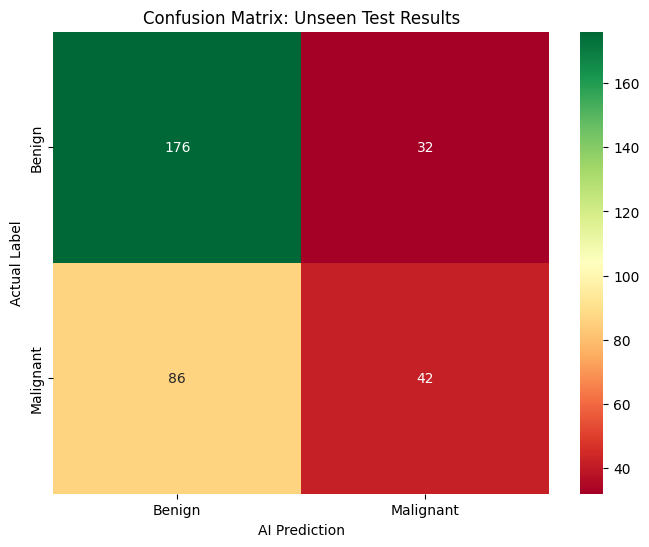


Visual Analysis of Test Samples:


/tmp/ipykernel_24/2465498795.py:36: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24/2465498795.py:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


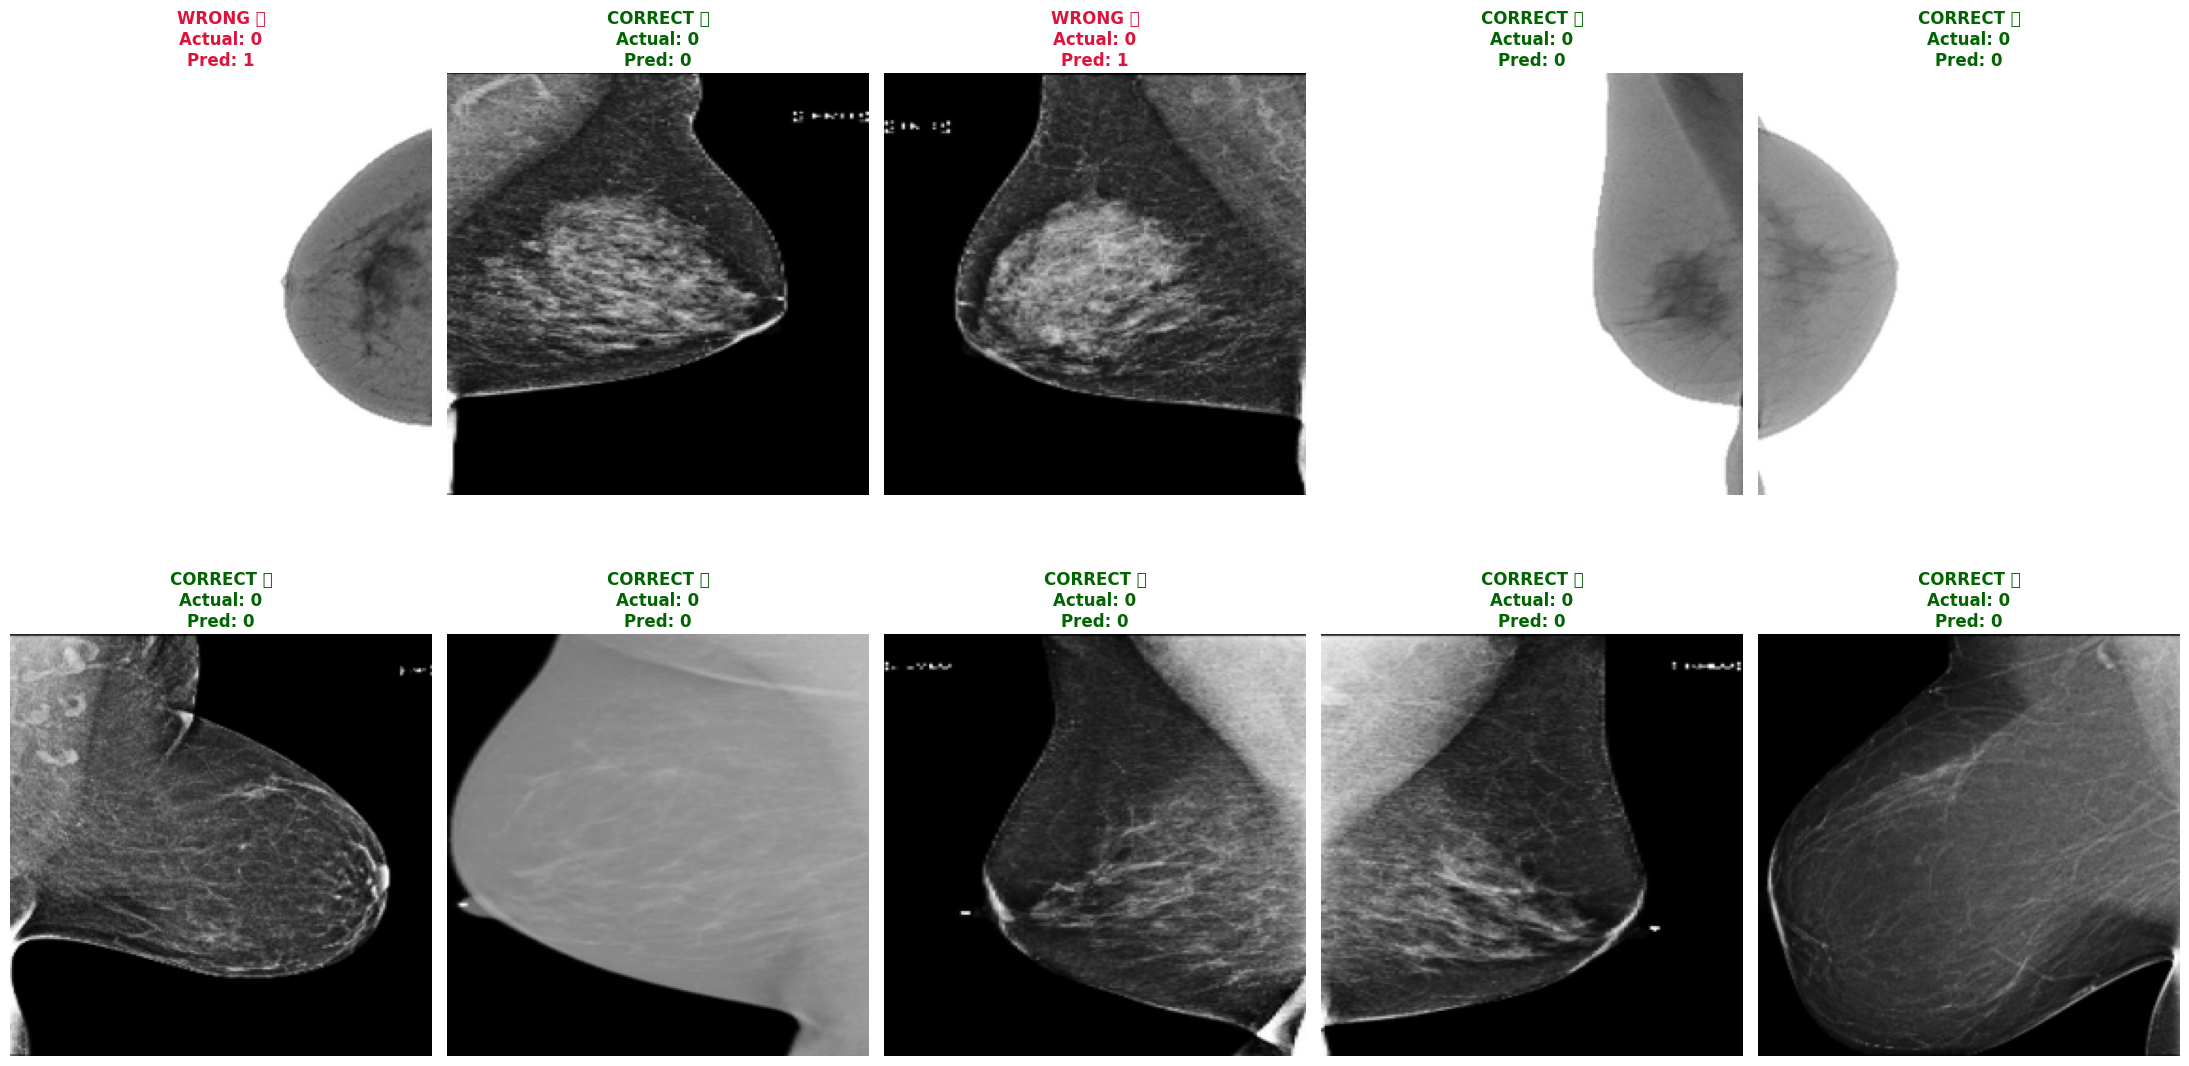


--- CLINICAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       208
           1       0.57      0.33      0.42       128

    accuracy                           0.65       336
   macro avg       0.62      0.59      0.58       336
weighted avg       0.63      0.65      0.62       336



In [7]:
# 1. Prediction on Unseen Test Set
print("Phase 5: Evaluating Unseen Test Set...")
test_results = trainer.predict(test_processed)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_processed["label"]

# 2. Confusion Matrix (Raw Performance)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Unseen Test Results')
plt.show()

# 3. Visual Performance Gallery (Audit of Correct vs Wrong)
def visualize_detailed_test(ds, preds, true_labels, n=10):
    plt.figure(figsize=(22, 12))
    for i in range(min(n, len(ds))):
        img = ds[i]["image"]
        actual_name = labels[true_labels[i]]
        pred_name = labels[preds[i]]
        
        is_correct = (preds[i] == true_labels[i])
        status = "CORRECT ✅" if is_correct else "WRONG ❌"
        color = "darkgreen" if is_correct else "crimson"
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{status}\nActual: {actual_name}\nPred: {pred_name}", 
                  color=color, fontsize=12, fontweight='bold')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("\nVisual Analysis of Test Samples:")
visualize_detailed_test(test_processed, test_preds, test_labels, n=10)

# 4. Final Detailed Report
print("\n--- CLINICAL CLASSIFICATION REPORT ---")
print(classification_report(test_labels, test_preds, target_names=labels))

# Clinical Optimization & Sensitivity Tuning
In this concluding phase, we transition from a standard machine learning evaluation to a clinical safety optimization. By extracting the raw probability scores rather than relying on the default 0.5 cutoff, we gain the ability to adjust the model's "sensitivity." We implement a custom threshold of 0.30, which intentionally lowers the bar for flagging a lesion as suspicious. This strategic adjustment significantly boosts the Malignant Recall, ensuring the model "catches" cancerous cases that were previously missed due to lower confidence scores. To validate this approach, we visualize the "Newly Caught" cancers—lesions that the AI was uncertain about but correctly identified under the new safety parameters. This final tuning demonstrates how AI can be calibrated to serve as a high-sensitivity screening tool, prioritizing patient safety by minimizing dangerous false negatives.

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--- Performance at Threshold: 0.3 ---
New Malignant Recall: 0.64 (Was 0.28)
New Malignant Precision: 0.49

New Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.65       208
           1       0.49      0.64      0.55       128

    accuracy                           0.60       336
   macro avg       0.60      0.61      0.60       336
weighted avg       0.63      0.60      0.61       336



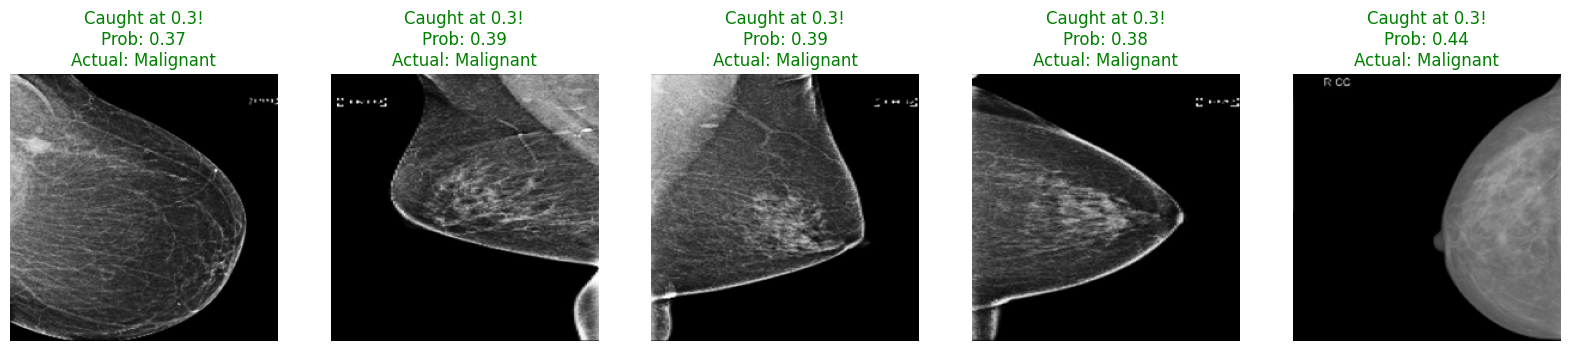

In [8]:
# 1. Get raw probabilities (logits) from the test set
test_results = trainer.predict(test_processed)
probabilities = torch.nn.functional.softmax(torch.tensor(test_results.predictions), dim=-1)

# 2. Extract probability of being 'Malignant' (Class 1)
malignant_probs = probabilities[:, 1].numpy()

# 3. SET NEW THRESHOLD: Lower this to catch more cancer
# Try 0.3 or 0.25
new_threshold = 0.30 
custom_preds = (malignant_probs >= new_threshold).astype(int)

# 4. Compare New Performance
from sklearn.metrics import recall_score, precision_score

print(f"--- Performance at Threshold: {new_threshold} ---")
print(f"New Malignant Recall: {recall_score(test_labels, custom_preds):.2f} (Was 0.28)")
print(f"New Malignant Precision: {precision_score(test_labels, custom_preds):.2f}")
print("\nNew Classification Report:")
print(classification_report(test_labels, custom_preds, target_names=labels))

# 5. Visualize the "Newly Caught" Cancers
def visualize_threshold_diff(ds, probs, actuals, threshold, n=5):
    plt.figure(figsize=(20, 8))
    # Find indices where model was unsure (between 0.3 and 0.5) but correct
    low_conf_indices = [i for i, p in enumerate(probs) if threshold <= p < 0.5 and actuals[i] == 1]
    
    for i, idx in enumerate(low_conf_indices[:n]):
        img = ds[idx]["image"]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Caught at {threshold}!\nProb: {probs[idx]:.2f}\nActual: Malignant", color="green")
        plt.axis("off")
    plt.show()

if any(0.3 <= p < 0.5 for p in malignant_probs):
    visualize_threshold_diff(test_processed, malignant_probs, test_labels, new_threshold)